In [57]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import Imputer,LabelEncoder,StandardScaler
from sklearn.base import TransformerMixin
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import BernoulliRBM

from lasagne.layers import InputLayer, DropoutLayer, DenseLayer
from lasagne.updates import nesterov_momentum
from lasagne.objectives import binary_crossentropy
from lasagne.init import Uniform
from nolearn.lasagne import NeuralNet, BatchIterator
import theano
from theano import tensor as T
from theano.tensor.nnet import sigmoid

import matplotlib.pyplot as plt
import corner

%matplotlib inline

In [58]:
# taken from http://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn
#updated for ints

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() if X[c].dtype == np.dtype('float64') else X[c].median() 
                               for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)


In [59]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [60]:
train.select_dtypes(include=['object']).keys()

Index([u'v3', u'v22', u'v24', u'v30', u'v31', u'v47', u'v52', u'v56', u'v66',
       u'v71', u'v74', u'v75', u'v79', u'v91', u'v107', u'v110', u'v112',
       u'v113', u'v125'],
      dtype='object')

In [61]:
keysToUse = set(train.keys())

keysToUse.remove('ID')
keysToUse.remove('target')

v22out = False

if v22out:
    keysToUse.remove('v22')

keysToUse = list(keysToUse)

nonNumericKeys = set(train.select_dtypes(include=['object']).keys())

if v22out:
    nonNumericKeys.remove('v22')

nonNumericKeys = list(nonNumericKeys)

In [62]:
bigX = train[keysToUse].append(test[keysToUse])

imput = False

if imput:
    bigXimputed = DataFrameImputer().fit_transform(bigX)
    le = LabelEncoder()
    for col in nonNumericKeys:
        bigXimputed[col] = le.fit_transform(bigXimputed[col])
    trainX = bigXimputed[:train.shape[0]].as_matrix()
    testX = bigXimputed[train.shape[0]:].as_matrix()
else:
    for col in bigX:
        if col in nonNumericKeys:
            bigX[col], tmp_indexer = pd.factorize(bigX[col])
        else:
            bigX.loc[bigX[col].isnull(), col] = -9999 #train_series.mean()
    trainX = bigX[:train.shape[0]].as_matrix()
    testX = bigX[train.shape[0]:].as_matrix()

In [63]:
trainY = train['target']
trainY32 = trainY.astype('int32')

In [64]:
gbm = xgb.XGBClassifier(max_depth=10, n_estimators=900, learning_rate=0.04,nthread=4,subsample=0.9,
                        colsample_bytree=0.9)
gbm.fit(trainX, trainY)

predictions = gbm.predict_proba(testX)[:,1]

print 'Done with XGBooster...'

Done with XGBooster...


In [65]:
ext = ExtraTreesClassifier(n_estimators=900,max_features=100,n_jobs=4,criterion= 'entropy', min_samples_split= 4,
                            max_depth=20, min_samples_leaf=2)

ext.fit(trainX,trainY)

predictions = np.vstack([predictions,ext.predict_proba(testX)[:,1]])

print 'Done with ExtraTrees...'

Done with ExtraTrees...


In [66]:
# aken from https://www.kaggle.com/ouranos/bnp-paribas-cardif-claims-management/lasagne-nn/run/165162/code

class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = np.float64(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)


In [67]:
scaler = StandardScaler()
scaler.fit(trainX)

trainXsc = scaler.transform(trainX)
testXsc = scaler.transform(testX)

In [68]:
#consider not dropping these

#trainXsc.drop(labels = "v22", axis = 1, inplace = True)
#testXsc.drop(labels = "v22", axis = 1, inplace = True)


In [69]:
net = NeuralNet(
    layers=[  
        ('input', InputLayer),
        ('dropout0', DropoutLayer),
        ('hidden1', DenseLayer),
        ('dropout1', DropoutLayer),
        ('hidden2', DenseLayer),
        ('output', DenseLayer),
        ],

    input_shape=(None, len(trainXsc[1])),
    dropout0_p=0.1,
    hidden1_num_units=100,
    hidden1_W=Uniform(),
    dropout1_p=0.2, 
    hidden2_num_units=100,
    #hidden2_W=Uniform(),

    output_nonlinearity=sigmoid,
    output_num_units=1, 
    update=nesterov_momentum,
    update_learning_rate=theano.shared(np.float64(0.0001)),
    update_momentum=theano.shared(np.float64(0.9)),    
    # Decay the learning rate
    on_epoch_finished=[AdjustVariable('update_learning_rate', start=0.0001, stop=0.00001),
                       AdjustVariable('update_momentum', start=0.9, stop=0.99),
                       ],
    regression=True,
    y_tensor_type = T.imatrix,                   
    objective_loss_function = binary_crossentropy,
    #batch_iterator_train = BatchIterator(batch_size = 256),
    max_epochs=300, 
    eval_size=0.1,
    #train_split =0.0,
    verbose=2,
    )

net.fit(trainXsc, trainY32)


# Neural Network with 23401 learnable parameters

## Layer information

  #  name        size
---  --------  ------
  0  input        131
  1  dropout0     131
  2  hidden1      100
  3  dropout1     100
  4  hidden2      100
  5  output         1

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.60435       0.55509      1.08873  1.34s
      2       0.55102       0.54904      1.00360  1.36s
      3       0.54653       0.54570      1.00152  1.38s
      4       0.54333       0.54252      1.00148  1.34s
      5       0.54026       0.53960      1.00123  1.32s
      6       0.53806       0.53701      1.00194  1.33s
      7       0.53564       0.53475      1.00168  1.33s
      8       0.53364       0.53282      1.00154  1.31s
      9       0.53226       0.53124      1.00192  1.32s
     10       0.53049       0.52987      1.00116  1.31s
     11       0.52936       0.52869      1.00127  1.33s
     12       0.52837    

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f13fa7d6290>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f13fa7d6150>,
     custom_scores=None, dropout0_p=0.1, dropout1_p=0.2,
     hidden1_W=<lasagne.init.Uniform object at 0x7f13e06d2910>,
     hidden1_num_units=100, hidden2_num_units=100, input_shape=(None, 131),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('dropout0', <class 'lasagne.layers.noise.DropoutLayer'>), ('hidden1', <class 'lasagne.layers.dense.DenseLayer'>), ('dropout1', <class 'lasagne.layers.noise.DropoutLayer'>), ('hidden2', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=300, more_params={},
     objective=<function objective at 0x7f13fa7d8230>,
     objective_loss_function=<function binary_crossentropy at 0x7f13fb0ebf50>,
     on_batch_finished=[],
     on_epoch_finished=[<__main__.

In [70]:
predictions = np.vstack([predictions,net.predict(testXsc)[:,0]])

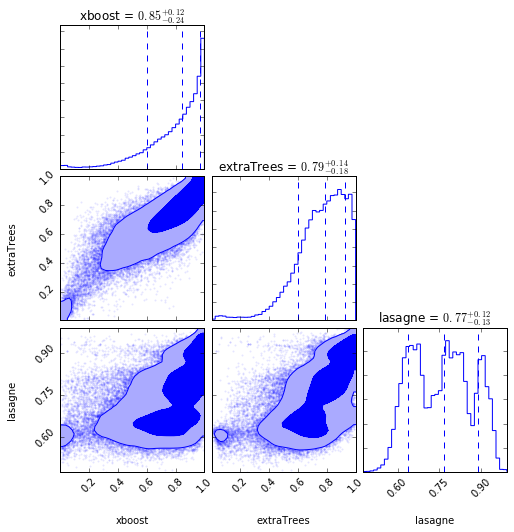

In [71]:
corner.corner(predictions.T, labels=['xboost','extraTrees','lasagne'],quantiles=[0.16,0.5,0.84],
                show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=True, fill_contours=True, levels=[0.68, 0.95], color='b', bins=40, smooth=1.0)

plt.show()


In [72]:
output = pd.DataFrame({'ID': test['ID'],'PredictedProb': np.mean(predictions,axis=0)})
output.to_csv('submission_tripple.csv',index=False)